In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc

C:\Users\19147\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [3]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [4]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [6]:

def load_bird_sound_paths_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    file_paths = []
    labels = []

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            file_paths.append(file_path)
            labels.append(row['species'])  
        else:
            print(f"File not found: {file_path}")

    return file_paths, labels


metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

file_paths, labels = load_bird_sound_paths_from_csv(metadata_path, audio_files_path)
print(file_paths[:5], labels[:5])


['C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-0.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-1.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-4.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-5.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-6.wav'] ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [7]:
# New function to load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=None)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio



In [8]:
def extract_mel_spectrogram(file_path, sr, n_fft=2048, hop_length=512, n_mels=128):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=None)
    
    # Calculate Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    return S  # Return the Mel spectrogram data directly



# Define variables
sr = 22050  # Default sampling rate from librosa
fixed_length = 5 * sr  # 5 seconds multiplied by sampling rate


# Extract mel spectrogram for the first file
mel_spectrogram = extract_mel_spectrogram(file_paths[0], sr)


In [9]:
mel_features_list = []
# Loop through each file path and extract features
for file_path in file_paths:
    mel_features = extract_mel_spectrogram(file_path,sr)
    mel_features_list.append(np.mean(mel_features, axis =1))
# Convert lists to numpy arrays for further processing 
mel_features_array = np.array(mel_features_list)

In [10]:
label_encoder = LabelEncoder()
y1_encoded = label_encoder.fit_transform(labels)

In [11]:
# Flatten each Mel spectrogram before adding to the list
mel_features_list = [mel_feature.flatten() for mel_feature in mel_features_list]
X4_train, X4_test, y4_train, y4_test, files4_train, files4_test = train_test_split(
    mel_features_list, y1_encoded, file_paths, test_size=0.2, random_state=42
)


In [12]:
scaler = StandardScaler()
X4_train_scaled = scaler.fit_transform(X4_train)
X4_test_scaled = scaler.transform(X4_test)

In [13]:
# Train Random Forest classifier
clf_mel = RandomForestClassifier(n_estimators=100)
clf_mel.fit(X4_train_scaled, y4_train)


RandomForestClassifier()

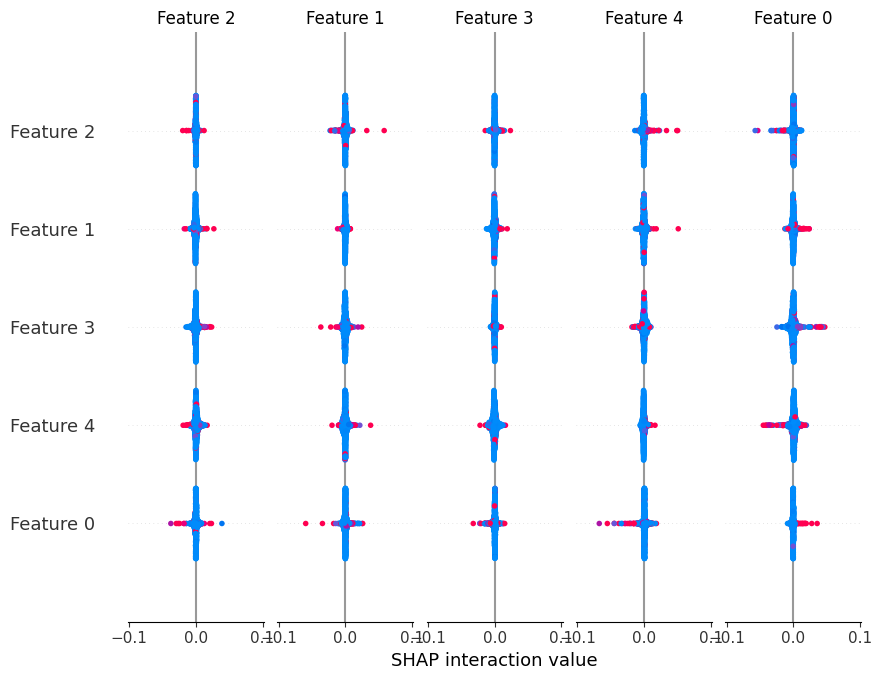

In [14]:
explainer = shap.TreeExplainer(clf_mel)
shap_values = explainer.shap_values(X4_test_scaled)

shap.summary_plot(shap_values, X4_test_scaled)

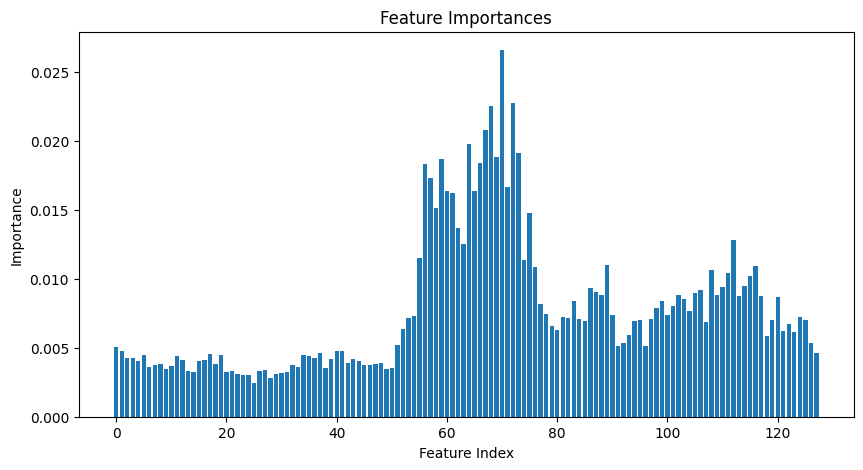

In [15]:
importances = clf_mel.feature_importances_
plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()
     

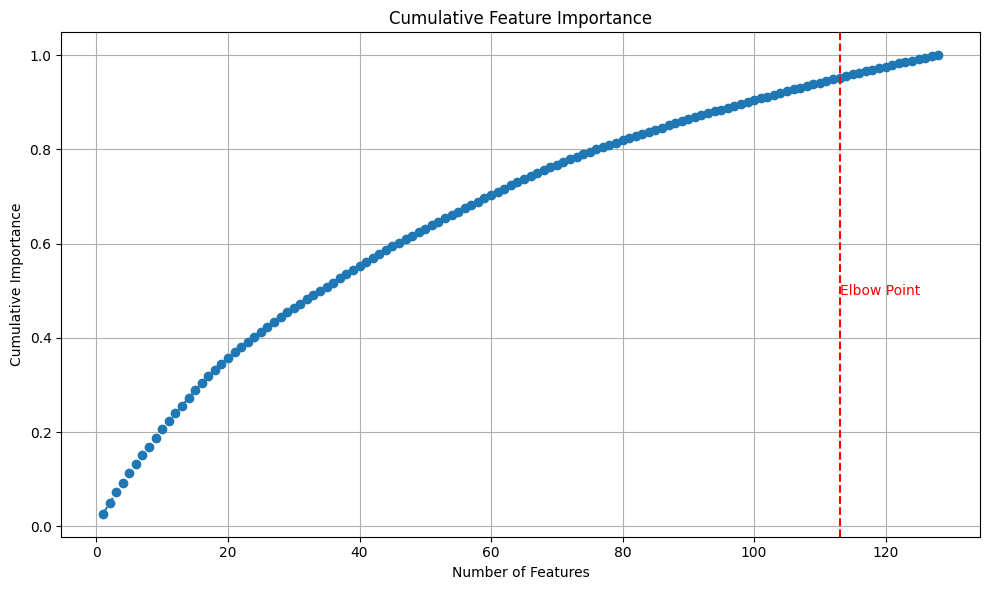

Elbow Point (95% cumulative importance): 113 features


In [20]:
# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_importances)

# Plot cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_importances) + 1), cumulative_importance, marker='o', linestyle='--')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)

# Mark the elbow point
elbow_point = np.argmax(cumulative_importance >= 0.95) + 1  # 95% threshold
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.text(elbow_point, 0.5, 'Elbow Point', color='r', verticalalignment='center')

plt.tight_layout()
plt.show()

print(f"Elbow Point (95% cumulative importance): {elbow_point} features")


In [16]:
clf_mel_predictions = clf_mel.predict(X4_test_scaled)

In [17]:
# Print accuracy and classification report
print(f"Accuracy with Mel features: {accuracy_score(y4_test, clf_mel_predictions)}")
print(f"Classification Report: \n{classification_report(y4_test, clf_mel_predictions)}\n")

Accuracy with Mel features: 0.880184331797235
Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       193
           1       0.89      0.87      0.88       204
           2       0.82      0.90      0.86       243
           3       0.91      0.92      0.91       207
           4       0.91      0.85      0.88       238

    accuracy                           0.88      1085
   macro avg       0.88      0.88      0.88      1085
weighted avg       0.88      0.88      0.88      1085




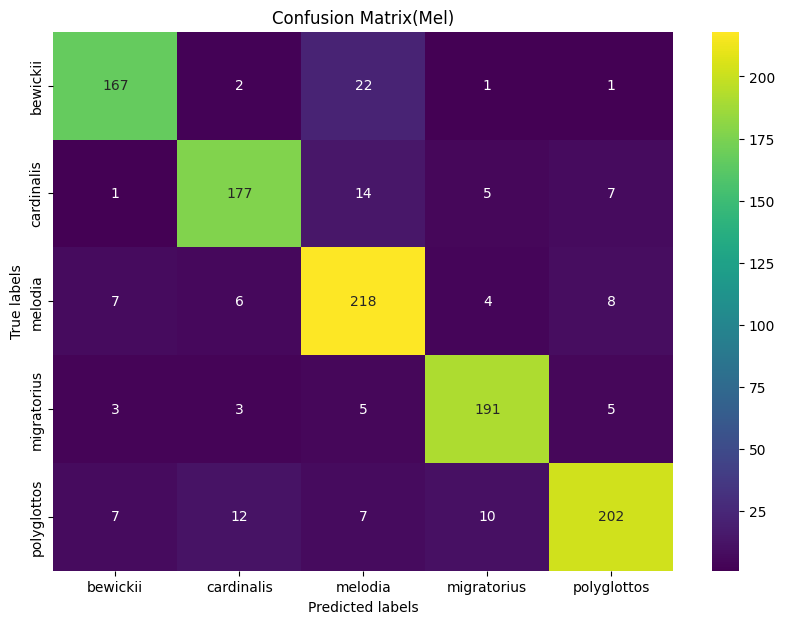

[[167   2  22   1   1]
 [  1 177  14   5   7]
 [  7   6 218   4   8]
 [  3   3   5 191   5]
 [  7  12   7  10 202]]


In [18]:
cm_Mel = confusion_matrix(y4_test, clf_mel_predictions)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Mel, annot=True, fmt='g', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix(Mel)')
plt.show()
print(cm_Mel)

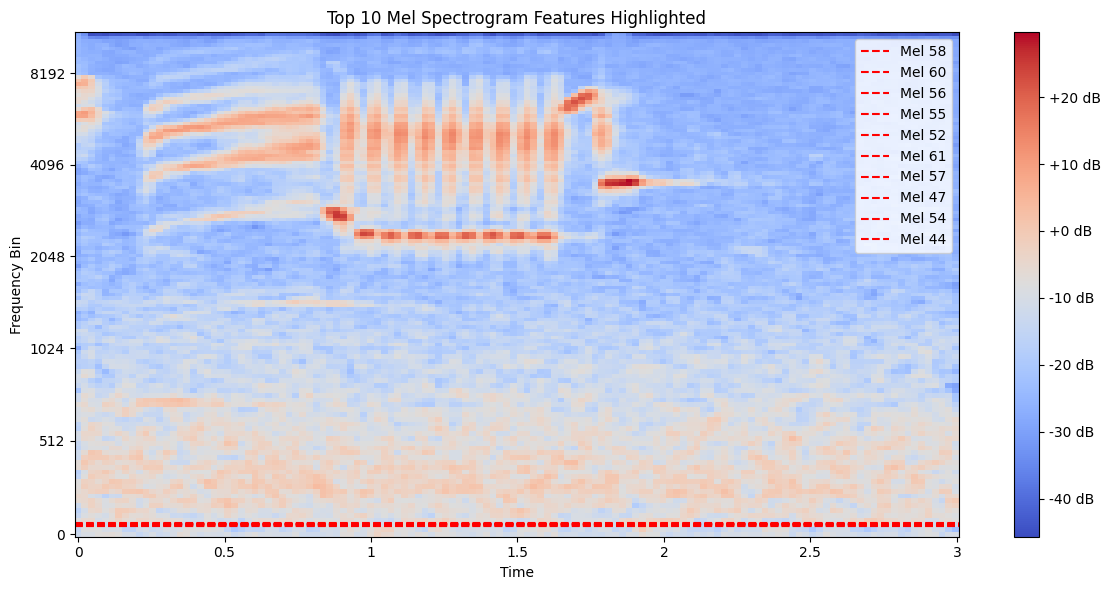

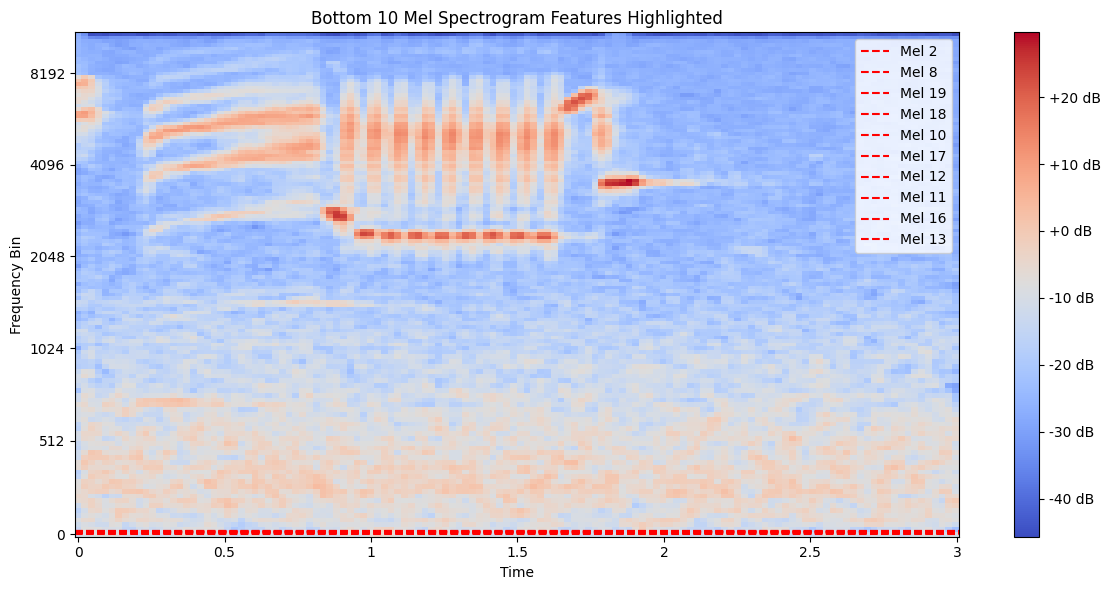

In [28]:


# Define Mel feature names starting from 1
mel_feature_names = ['Mel_{}'.format(i + 1) for i in range(128)]

# Assuming clf_mel is your trained model with Log Mel features
importances = clf_mel.feature_importances_

# Sort indices by importance
indices = np.argsort(importances)[::-1]

# Filter only Mel spectrogram feature indices (0-based for importances array)
mel_indices = [i for i in indices if i >= 13]

# Adjust indices to match Mel feature names (1-based display)
mel_indices_adjusted = np.array(mel_indices) - 13

# Get the top 5 Mel spectrogram features
top_mel_indices = mel_indices_adjusted[:10]

# Get the bottom 5 Mel spectrogram features
bottom_mel_indices = mel_indices_adjusted[-10:]

# Get the corresponding feature names
top_mel_feature_names = [mel_feature_names[i] for i in top_mel_indices]
bottom_mel_feature_names = [mel_feature_names[i] for i in bottom_mel_indices]


example_audio_path = file_paths[128]
audio, sr = librosa.load(example_audio_path, sr=22050)

# Function to plot Mel spectrogram with highlighted features
def plot_highlighted_mel_spectrogram(audio, sr, feature_indices, title):
    # Extract Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec)

    plt.figure(figsize=(12, 6))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel')
    for idx in feature_indices:
        plt.axhline(y=idx, color='r', linestyle='--', label=f'Mel {idx + 1}')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency Bin')
    plt.colorbar(format='%+2.0f dB')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Visualize Mel spectrogram with top 5 highlighted features
plot_highlighted_mel_spectrogram(audio, sr, top_mel_indices, 'Top 10 Mel Spectrogram Features Highlighted')

# Visualize Mel spectrogram with bottom 5 highlighted features
plot_highlighted_mel_spectrogram(audio, sr, bottom_mel_indices, 'Bottom 10 Mel Spectrogram Features Highlighted')
